# imports

In [1]:
!pip install conllu
from conllu import parse

In [2]:
from gensim.models import Word2Vec
import numpy as np


In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data

In [6]:
train_path = '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/UD_English-Atis/en_atis-ud-train.conllu'
test_path = '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/UD_English-Atis/en_atis-ud-test.conllu'
dev_path = '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/UD_English-Atis/en_atis-ud-dev.conllu'
conllu_data = None

with open(train_path, 'r', encoding='utf-8') as f:
    conllu_data = f.read()

train_sentences = parse(conllu_data)

with open(test_path, 'r', encoding='utf-8') as f:
    conllu_data = f.read()

test_sentences = parse(conllu_data)

with open(dev_path, 'r', encoding='utf-8') as f:
    conllu_data = f.read()

dev_sentences = parse(conllu_data)



In [7]:
word_to_ix = dict()
tag_to_ix = dict()

In [8]:
for sentence in train_sentences:
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] not in word_to_ix:
      word_to_ix[token['form']] = len(word_to_ix)
    if token['upos'] not in tag_to_ix:
      tag_to_ix[token['upos']] = len(tag_to_ix)

for sentence in test_sentences:
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] not in word_to_ix:
      word_to_ix[token['form']] = len(word_to_ix)
    if token['upos'] not in tag_to_ix:
      tag_to_ix[token['upos']] = len(tag_to_ix)

for sentence in dev_sentences:
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] not in word_to_ix:
      word_to_ix[token['form']] = len(word_to_ix)
    if token['upos'] not in tag_to_ix:
      tag_to_ix[token['upos']] = len(tag_to_ix)

In [9]:
tag_to_ix = {
              'PRON': 0,
              'AUX': 1,
              'DET': 2,
              'NOUN': 3,
              'ADP': 4,
              'PROPN': 5,
              'VERB': 6,
              'NUM': 7,
              'ADJ': 8,
              'CCONJ': 9,
              'ADV': 10,
              'PART': 11,
              'INTJ': 12
            }

In [10]:
train_s = []
train_label = []
for sentence in train_sentences:
  temp = [  ]
  temp2 = []
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    temp.append(token['form'])
    temp2.append(token['upos'])
  train_label.append(temp2)
  train_s.append(temp)

dev_s = []
dev_label = []
for sentence in dev_sentences:
  temp = [  ]
  temp2 = []
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    temp.append(token['form'])
    temp2.append(token['upos'])
  dev_label.append(temp2)
  dev_s.append(temp)

test_s = []
test_label = []
for sentence in test_sentences:
  temp = [  ]
  temp2 = []
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    temp.append(token['form'])
    temp2.append(token['upos'])
  test_label.append(temp2)
  test_s.append(temp)

# Helper Functions

### Plotting and testing

In [15]:

def plot_accuracy(epochs,acc,text):
    plt.rcParams["figure.figsize"] = [6, 4]
    plt.plot(epochs, acc, marker=".", markersize=5, markeredgecolor="blue", markerfacecolor="lightyellow")
    plt.title(f'epoch vs Accuracy({text})',fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')


def plot_loss(epochs,train_l,test_l,text):
  plt.rcParams["figure.figsize"] = [6, 4]
  plt.rcParams["figure.autolayout"] = True
  plt.plot(epochs, train_l, marker=".", markeredgecolor="blue", markerfacecolor="lightyellow",label='line1')
  plt.plot(epochs, test_l, marker=".", markeredgecolor="red", markerfacecolor="lightyellow",label='line2')
  plt.title(f'Loss vs Epoch({text})',fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

In [16]:
def evaluate_classification(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='micro')

    # Calculate F1 score
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Recall (micro):", recall)
    print("F1 Score (micro):", f1_micro)
    print("F1 Score (macro):", f1_macro)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(13), yticklabels=range(13))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    # return accuracy, recall, f1_micro, f1_macro, cm

In [17]:
def tets_on(test_data,test_label,model,batch_size,word_to_ix,tag_to_ix):
  pred_label = []
  actual_label = []
  with torch.no_grad():
    for i in range(0, len(test_data), batch_size):
      sentences = test_data[i:i+batch_size]
      tags_list = test_label[i:i+batch_size]

      input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
      targets = [torch.tensor([tag_to_ix[tag] for tag in tags], dtype=torch.long) for tags in tags_list]

      for sen in targets:
        actual_label.extend(sen.tolist())

      input_seqs_padded = pad_sequence(input_seqs, batch_first=True)
      lengths = [len(seq) for seq in input_seqs]

      outputs = model(input_seqs_padded, lengths)



      _, predicted_tags = torch.max(outputs, 2)
      # print(c)

      for p in range(len(predicted_tags)):
        x = predicted_tags[p][:lengths[p]]
        # print(x)
        pred_label.extend(x.tolist())

  return actual_label,pred_label

### Tarining

In [18]:
def prepare_windows(sentences,n,p):
  train_data = []
  for sentence in sentences:
    k = len(sentence)
    temp = [ 'SOS' for i in range(p)]
    temp.extend(sentence)
    temp.extend(["EOS" for i in range(n)])

    for i in range(k):
      train_data.append(temp[i:(i + n+p+1)])

  return train_data

In [19]:
def train_the_model(model, loss_function, optimizer,train_s,train_label,word_to_ix,tag_to_ix,dev_s,dev_label ,epochs):

  train_loss_1 = []
  test_loss_1 = []
  accuracies_1 = []
  for epoch in range(epochs):
    model.train()
    train_loss_epoch = []
    test_loss_epoch = []

    for i in range(0, len(train_s), batch_size):
      sentences = train_s[i:i+batch_size]
      tags_list = train_label[i:i+batch_size]

      input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
      targets = [torch.tensor([tag_to_ix[tag] for tag in tags], dtype=torch.long) for tags in tags_list]

      input_seqs_padded = pad_sequence(input_seqs, batch_first=True)

      optimizer.zero_grad()
      lengths = [len(seq) for seq in input_seqs]

      model.zero_grad()

      outputs = model(input_seqs_padded, lengths)

      total_loss = 0
      for output, target, length in zip(outputs, targets, lengths):
            loss = loss_function(output[:length].view(-1, tagset_size), target[:length])
            total_loss += loss

      total_loss.backward()
      optimizer.step()
      train_loss_epoch.append(total_loss.item())

      # loop.set_description(f'Epoch: {epoch}')
    print(epoch+1,end=" ")

    model.eval()
    # correct,total = 0,0
    tot = 0
    corr = 0
    with torch.no_grad():
      for i in range(0, len(dev_s), batch_size):
        sentences = dev_s[i:i+batch_size]
        tags_list = dev_label[i:i+batch_size]

        input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
        targets = [torch.tensor([tag_to_ix[tag] for tag in tags], dtype=torch.long) for tags in tags_list]

        input_seqs_padded = pad_sequence(input_seqs, batch_first=True)
        lengths = [len(seq) for seq in input_seqs]

        outputs = model(input_seqs_padded, lengths)

        total_loss_temp = 0
        for output, target, length in zip(outputs, targets, lengths):
              loss = loss_function(output[:length].view(-1, tagset_size), target[:length])
              total_loss_temp += loss



        test_loss_epoch.append(total_loss_temp.item())

        _, predicted_tags = torch.max(outputs, 2)

        for p in range(len(predicted_tags)):
          x = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag.item())] for tag in predicted_tags[p]]
          for i,k in enumerate(x):
            if i >= lengths[p] :
              break
            if k == tags_list[p][i]:
              corr += 1
          tot += len(x)

    train_loss_1.append(np.mean(train_loss_epoch))
    test_loss_1.append(np.mean(test_loss_epoch))
    accuracy = 100*corr/tot
    accuracies_1.append(accuracy)
    print(np.mean(train_loss_epoch), np.mean(test_loss_epoch), end=" ")
    print(accuracy)

  return train_loss_1, test_loss_1, accuracies_1, model


# Models

In [27]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        # Convert input indices to embeddings
        embeds = self.embedding(x)

        # Pack the sequences
        packed_embeds = nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)

        # Initialize hidden state
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        # Forward pass through RNN
        packed_out, hidden = self.rnn_cell(packed_embeds, hidden)

        # Unpack the sequences
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        # Output from the fully connected layer
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

# CONF 1


In [ ]:

# Hyperparameters
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 50
hidden_dim = 20
learning_rate = 0.1
batch_size = 1

In [ ]:

model3 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, tagset_size)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [ ]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_s,train_label,word_to_ix,tag_to_ix,dev_s,dev_label,10 )

1 0.3153880821787674 0.35459353014840206 88.5426076482987
2 0.15967002460476146 0.21605218914995855 92.42697982535381
3 0.11968744381305277 0.17447342726869478 93.72177055103884
4 0.09852078036412719 0.15309012675549696 94.35411020776874
5 0.08493204938923875 0.13839647274528885 94.83589280337247
6 0.07568975138460937 0.13229733287944265 94.80578139114725
7 0.06907902607869253 0.13109055964676983 95.00150557061126
8 0.06432519698680839 0.13051045090209287 95.09183980728696
9 0.06076039243944174 0.13182784712874696 95.06172839506173
10 0.05797356833213835 0.13319071949614875 95.04667268894912


In [ ]:
accuracies_8

[88.5426076482987,
 92.42697982535381,
 93.72177055103884,
 94.35411020776874,
 94.83589280337247,
 94.80578139114725,
 95.00150557061126,
 95.09183980728696,
 95.06172839506173,
 95.04667268894912]

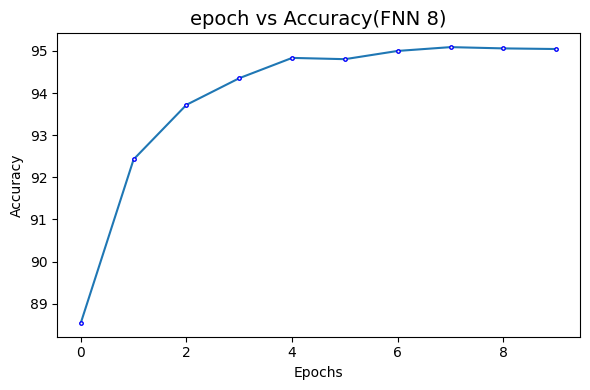

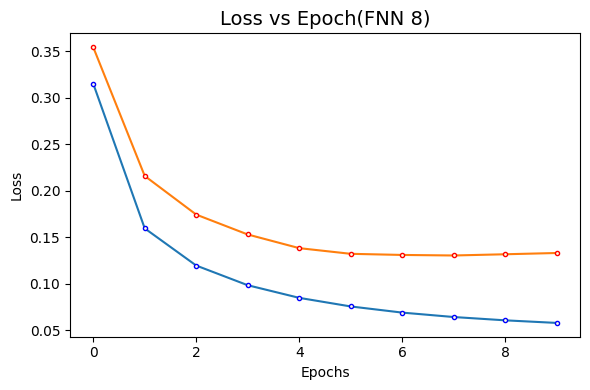

In [ ]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9504667268894911
Recall (micro): 0.9504667268894911
F1 Score (micro): 0.9504667268894911
F1 Score (macro): 0.9241342572856399


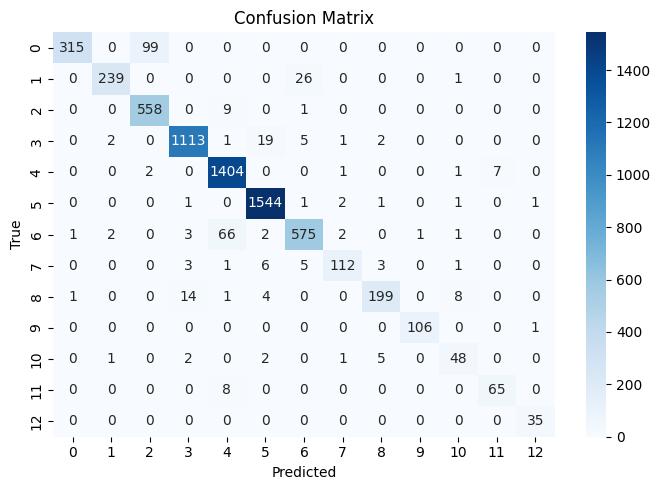

In [ ]:
actual_label, pred_label = tets_on(dev_s,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9507598784194529
Recall (micro): 0.9507598784194529
F1 Score (micro): 0.9507598784194529
F1 Score (macro): 0.9293503940883175


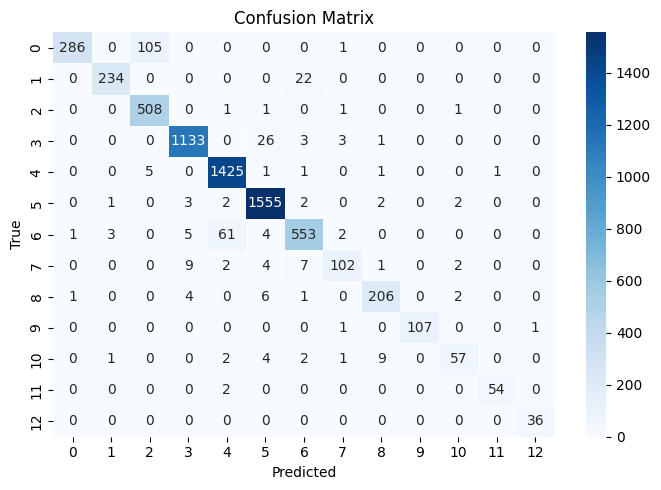

In [ ]:
actual_label, pred_label = tets_on(test_s,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [ ]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/vanilla_rnn_model_1.pth')

# CONF 2


In [42]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 100
hidden_dim = 50
learning_rate = 0.07
batch_size = 1

In [43]:

model3 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, tagset_size)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [44]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_s,train_label,word_to_ix,tag_to_ix,dev_s,dev_label,10 )

1 0.5764198486506241 0.5738985956340403 86.84131285757302
2 0.38465737148066464 0.4424065094623532 89.56639566395664
3 0.33399692821548704 0.39581666049267444 90.60523938572719
4 0.3071562312909471 0.37538881915119976 91.19241192411924
5 0.29257201919376596 0.36463169541235985 91.11713339355616
6 0.2810132472113884 0.36341442258937373 90.93646492020476
7 0.27222335990561913 0.3577836597716058 91.40319180969587
8 0.26577926039779415 0.3569254270279324 91.6892502258356
9 0.26007534378235675 0.3540785767893483 92.11080999698886
10 0.2555367124132258 0.35305203873846497 91.8849744052996


In [45]:
accuracies_8

[86.84131285757302,
 89.56639566395664,
 90.60523938572719,
 91.19241192411924,
 91.11713339355616,
 90.93646492020476,
 91.40319180969587,
 91.6892502258356,
 92.11080999698886,
 91.8849744052996]

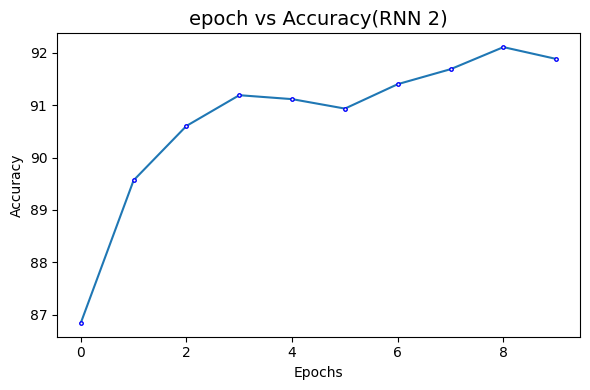

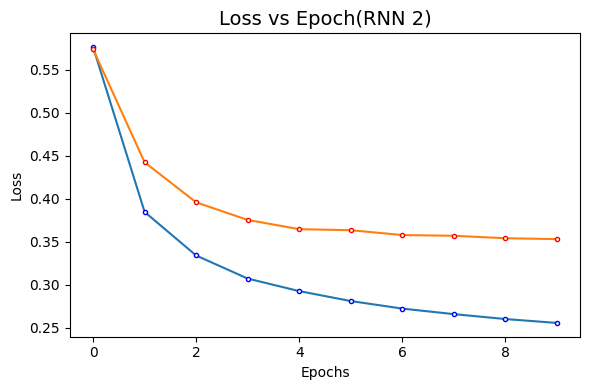

In [49]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'RNN 2')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'RNN 2')

Accuracy: 0.9188497440529961
Recall (micro): 0.9188497440529961
F1 Score (micro): 0.9188497440529961
F1 Score (macro): 0.8066397337735602


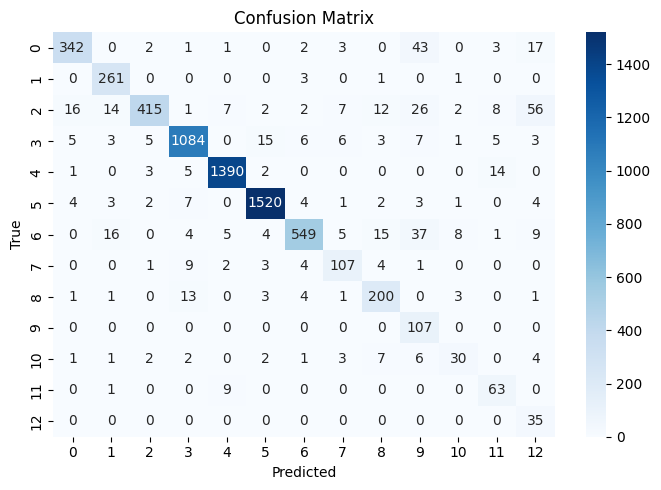

In [47]:
actual_label, pred_label = tets_on(dev_s,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9124620060790274
Recall (micro): 0.9124620060790274
F1 Score (micro): 0.9124620060790275
F1 Score (macro): 0.7851919476112363


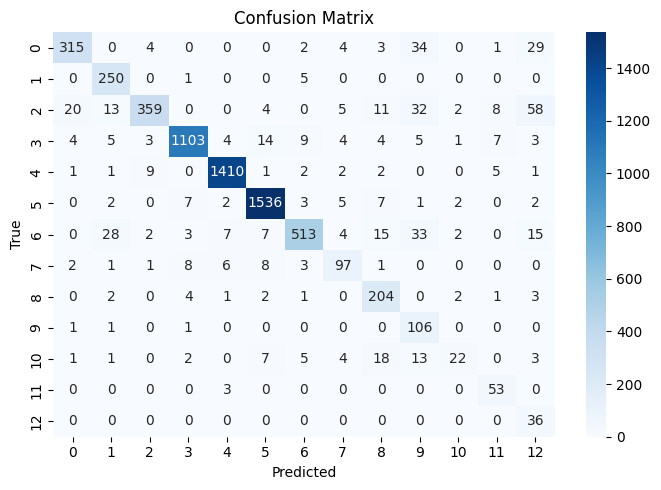

In [48]:
actual_label, pred_label = tets_on(test_s,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [50]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/vanilla_rnn_model_2.pth')

# CONF 3


In [51]:

# Hyperparameters
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 20
hidden_dim = 20
learning_rate = 0.01
batch_size = 1

In [52]:

model3 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, tagset_size)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [53]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_s,train_label,word_to_ix,tag_to_ix,dev_s,dev_label,10 )

1 1.6803424349303104 1.268108480876976 68.63896416741945
2 1.0465469109674563 0.9942363454224347 74.3751881963264
3 0.8647061830293257 0.8717239031216482 77.10027100271003
4 0.7658964435268798 0.795086033694394 78.53056308340861
5 0.7016834345379052 0.7418295698097119 79.73501957241794
6 0.654630612594171 0.6991122775300816 80.89430894308943
7 0.6179986567971691 0.6644868885876832 81.64709424872026
8 0.588514436153145 0.6360406004205034 82.24932249322494
9 0.5641542029857747 0.6119104461496944 82.89671785606745
10 0.5436111765246443 0.5908480450458877 83.67961457392352


In [54]:
accuracies_8

[68.63896416741945,
 74.3751881963264,
 77.10027100271003,
 78.53056308340861,
 79.73501957241794,
 80.89430894308943,
 81.64709424872026,
 82.24932249322494,
 82.89671785606745,
 83.67961457392352]

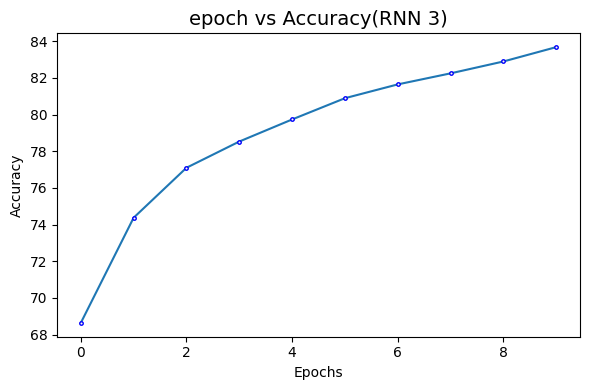

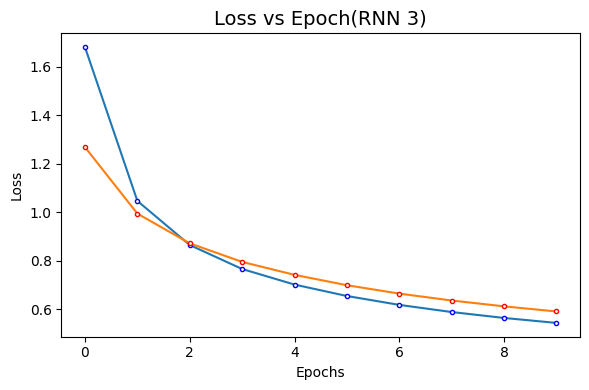

In [56]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'RNN 3')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'RNN 3')

Accuracy: 0.8367961457392352
Recall (micro): 0.8367961457392352
F1 Score (micro): 0.8367961457392352
F1 Score (macro): 0.6448543295068666


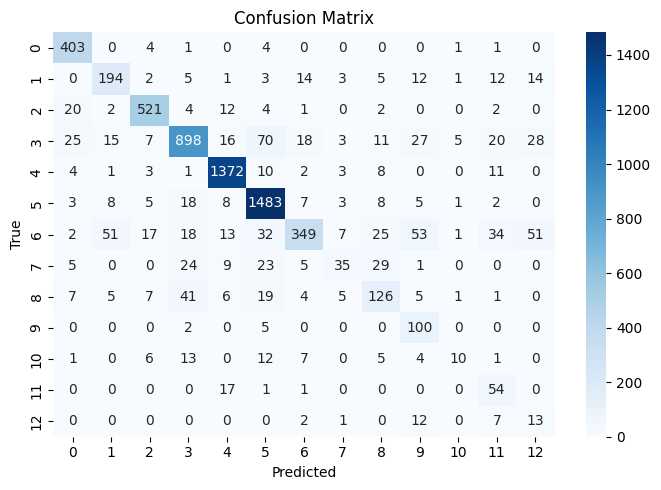

In [57]:
actual_label, pred_label = tets_on(dev_s,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.8349544072948328
Recall (micro): 0.8349544072948328
F1 Score (micro): 0.834954407294833
F1 Score (macro): 0.6453843087199294


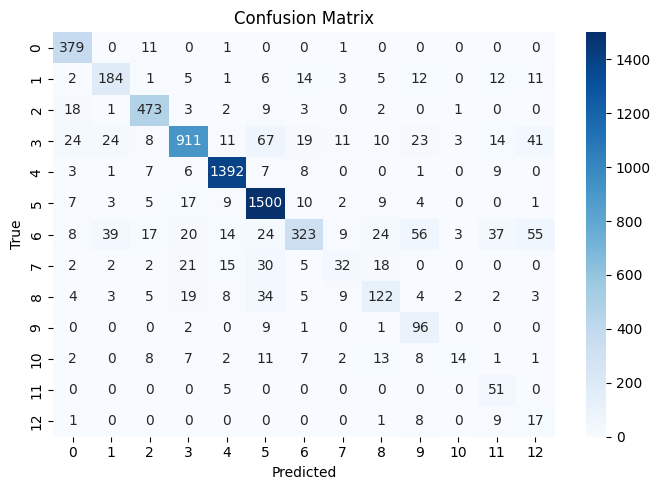

In [58]:
actual_label, pred_label = tets_on(test_s,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [59]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/vanilla_rnn_model_3.pth')

# CONF 4


In [60]:

# Hyperparameters
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 50
hidden_dim = 20
learning_rate = 0.1
batch_size = 2

In [61]:

model3 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, tagset_size)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [62]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_s,train_label,word_to_ix,tag_to_ix,dev_s,dev_label,10 )

1 1.2364635032139262 1.2344211265965774 72.66343207354443
2 0.7388359866914316 0.9492664874850453 76.28958120531155
3 0.6090987819235181 0.7926884569436103 77.50255362614914
4 0.5421768750857682 0.731762150159249 78.30694586312563
5 0.5024166713334938 0.6721723951347225 78.94535240040858
6 0.47355078182727534 0.6469177934308569 79.2517875383044
7 0.45252479118794886 0.6312387722147095 79.30286006128702
8 0.43451716751557506 0.6199442573881649 79.44330949948927
9 0.42244762333897046 0.6006388370911558 79.41777323799796
10 0.41151857366336525 0.5812157327113868 79.4688457609806


In [63]:
accuracies_8

[72.66343207354443,
 76.28958120531155,
 77.50255362614914,
 78.30694586312563,
 78.94535240040858,
 79.2517875383044,
 79.30286006128702,
 79.44330949948927,
 79.41777323799796,
 79.4688457609806]

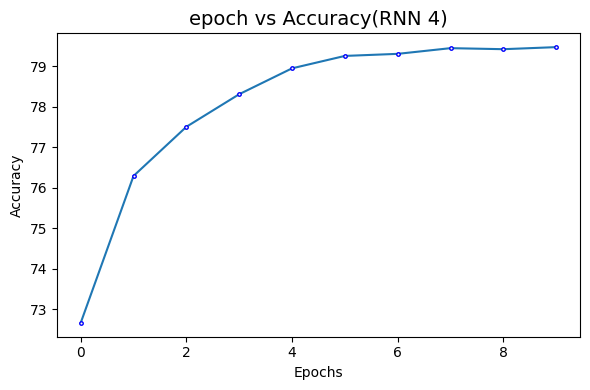

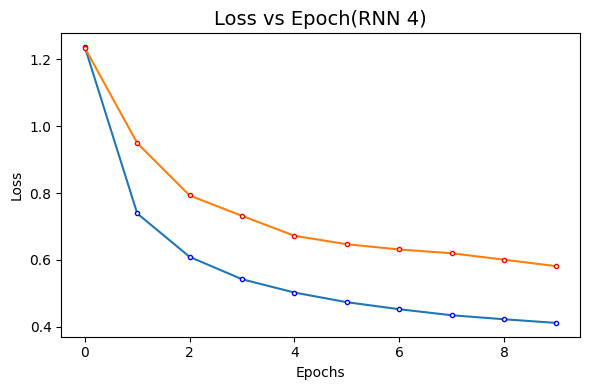

In [64]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'RNN 4')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'RNN 4')

Accuracy: 0.9370671484492623
Recall (micro): 0.9370671484492623
F1 Score (micro): 0.9370671484492623
F1 Score (macro): 0.8585169592568442


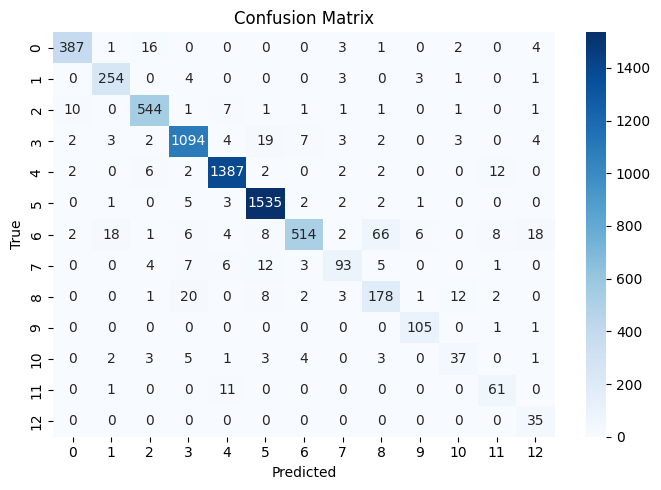

In [65]:
actual_label, pred_label = tets_on(dev_s,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9337386018237082
Recall (micro): 0.9337386018237082
F1 Score (micro): 0.9337386018237082
F1 Score (macro): 0.8434242117847301


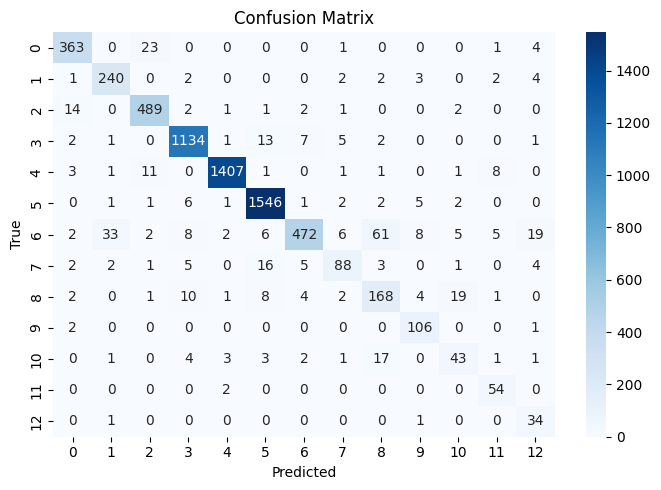

In [66]:
actual_label, pred_label = tets_on(test_s,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [67]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/vanilla_rnn_model_4.pth')

# CONF 5


In [68]:

# Hyperparameters
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 50
hidden_dim = 50
learning_rate = 0.1
batch_size = 1

In [69]:

model3 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, tagset_size)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [70]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_s,train_label,word_to_ix,tag_to_ix,dev_s,dev_label,10 )

1 0.5985436831985783 0.6185746439244155 83.52905751279735
2 0.4048305915151738 0.48993791147441296 87.33815115928937
3 0.35360041755449007 0.42955358372024305 89.28033724781692
4 0.32424806653895444 0.3967216521032623 90.2439024390244
5 0.3061545179877038 0.38107612559741194 91.10207768744354
6 0.2938057021523364 0.365113136182715 91.47847034025895
7 0.28371266327766986 0.3573847788327432 91.43330322192111
8 0.27578437291556396 0.3526667008971001 91.61397169527251
9 0.2695169580902488 0.3509111388267337 91.52363745859681
10 0.26554944630142235 0.3476110663056582 91.83980728696176


In [71]:
accuracies_8

[83.52905751279735,
 87.33815115928937,
 89.28033724781692,
 90.2439024390244,
 91.10207768744354,
 91.47847034025895,
 91.43330322192111,
 91.61397169527251,
 91.52363745859681,
 91.83980728696176]

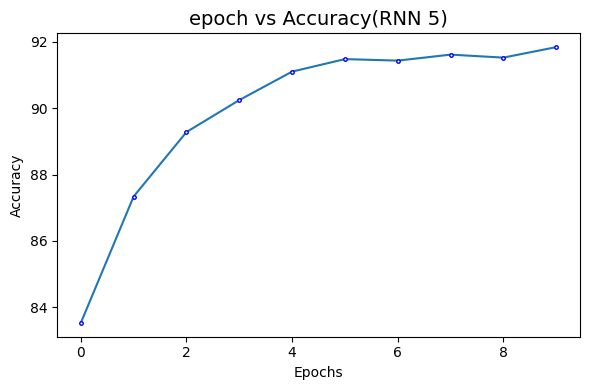

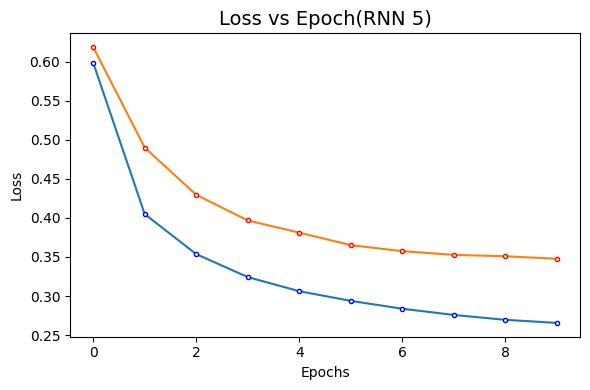

In [72]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'RNN 5')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'RNN 5')

Accuracy: 0.9183980728696176
Recall (micro): 0.9183980728696176
F1 Score (micro): 0.9183980728696176
F1 Score (macro): 0.7981641235208994


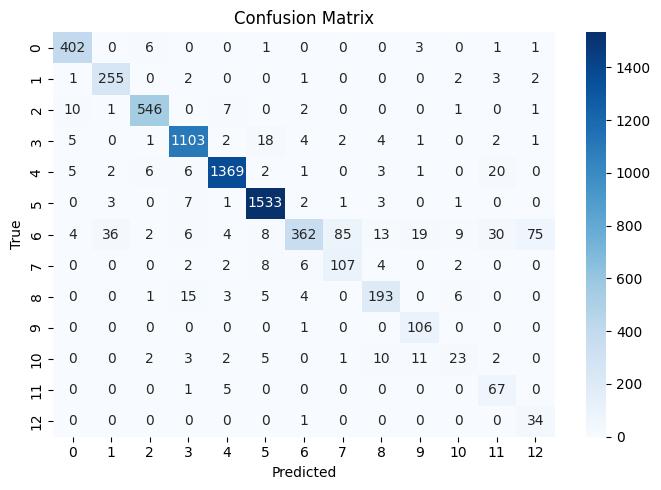

In [73]:
actual_label, pred_label = tets_on(dev_s,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9159574468085107
Recall (micro): 0.9159574468085107
F1 Score (micro): 0.9159574468085107
F1 Score (macro): 0.7960137061973285


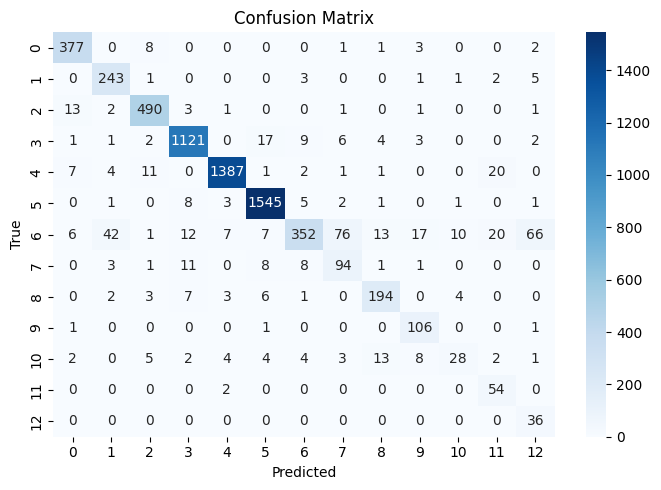

In [74]:
actual_label, pred_label = tets_on(test_s,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [75]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/vanilla_rnn_model_5.pth')